## 赛题说明
本题目提供的数据来自文件（windows 可执行程序）经过沙箱程序模拟运行后的API指令序列，全为windows二进制可执行程序，经过脱敏处理；

本题目提供的样本数据均来自于从互联网，其中恶意文件的类型有感染型病毒、木马程序、挖矿程序、DDOS木马、勒索病毒等，数据总计6亿条；

## 数据说明
**训练数据**（train.zip）：调用记录近9000万次，文件1万多个（以文件编号汇总），字段描述如下：

字段 | 类型 | 解释
-|-|-
file_id | bigint | 文件编号
label | bigint | 文件标签，0-正常/1-勒索病毒/2-挖矿程序/3-DDoS木马/4-蠕虫病毒/5-感染型病毒/6-后门程序/7-木马程序
api | string | 文件调用的API名称
tid | bigint | 调用API的线程编号
index | string | 线程中API调用的顺序编号

- 注1：一个文件调用的api数量有可能很多，对于一个tid中调用超过5000个api的文件，我们进行了截断，按照顺序保留了每个tid前5000个api的记录。
- 注2：不同线程tid之间没有顺序关系，同一个tid里的index由小到大代表调用的先后顺序关系。
- 注3：index是单个文件在沙箱执行时的全局顺序，由于沙箱执行时间有精度限制，所以会出现一个index上出现同线程或者不同线程都在执行多次api的情况，可以保证同tid内部的顺序，但不保证连续。
 
**测试数据**（test.zip）：调用记录近8000万次，文件1万多个。
> 说明：格式除了没有label字段，其他数据规格与训练数据一致。

## 评测指标
- 选手的结果文件包含9个字段：file_id(bigint)、和八个分类的预测概率prob0, prob1, prob2, prob3, prob4, prob5 ,prob6,prob7 (类型double，范围在[0,1]之间，精度保留小数点后5位，prob<=0.0我们会替换为1e-6，prob>=1.0我们会替换为1.0-1e-6)。选手必须保证每一行的|prob0+prob1+prob2+prob3+prob4+prob5+prob6+prob7-1.0|<1e-6，且将列名按如下顺序写入提交结果文件的第一行，作为表头：file_id,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7。

- 分数采用logloss计算公式

## 字段分析

- file_id：表现每个程序文件，其中包含正常与各种异常类型，因此可以通过该字段做分组统计分析；
- label：训练标签，因此该问题是有监督学习；
- api：程序调用的api，由于是string类型，需要转为普通离散数据，且只支持连续值的算法此处不适用；
- tid：通过tid可以分组统计某个文件在某个线程中的调用时序，此处考虑HMM算法求转换概率；
- index：配合tid进行调用时序统计分析；

## 问题分析

简单讲模型需要预测一个未知文件为各个类别的概率，且概率和为1（接近1），训练数据有标签，因此是有监督学习，8个目标类别，因此是一个有监督多分类问题，目前还没有看过数据，但是通常存在极端的不平衡的情况，异常的文件数量远小于正常的文件，但这里跟普通异常检测不同的在于它需要精确的给出是哪一种异常，而不是简单的区分正常/异常，且需要算法输出的是各个类别的概率，而不是0/1；

## 环境

In [78]:
#coding:utf-8
## 导入模块以及环境设置
import os,sys,time,re
from gc import collect as gcc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

%matplotlib inline

## 数据加载

由于数据量很大，训练csv文件2.9G，9000W条记录，1w个文件，因此采用pandas的分段加载方法，只加载部分数据做可视化分析；

In [2]:
train_path = '../../../../../ali_tianchi_dataset/恶意程序检测/security_train.csv'
test_path = '../../../../../ali_tianchi_dataset/恶意程序检测/security_test.csv'
submit_path = '../../../../../ali_tianchi_dataset/恶意程序检测/security_submit.csv'

In [3]:
def get_chunks(file_path=train_path, chunksize=100000):
    chunks = pd.read_csv(file_path, chunksize=chunksize)
    return chunksize

In [101]:
train_data = pd.read_csv(train_path, nrows=4000*10000)

In [102]:
train_data.head(5)

,file_id,label,api,tid,index
0,1,5,LdrLoadDll,2488,0
1,1,5,LdrGetProcedureAddress,2488,1
2,1,5,LdrGetProcedureAddress,2488,2
3,1,5,LdrGetProcedureAddress,2488,3
4,1,5,LdrGetProcedureAddress,2488,4


## 数据可视化分析

### 根据文件id分组

In [103]:
def groupby_fileid_nolabel(data):
    file_data = pd.DataFrame(columns=['file_id','api_type_count',
                                      'tid_type_count','api_call_count'])
    for name,group in data.groupby('file_id'):
        file_data = file_data.append([{'file_id':name,'api_type_count':len(group.api.unique()),
                                       'tid_type_count':len(group.tid.unique()),
                            'api_call_count':group.tid.count()}], ignore_index=True)
    return file_data

def groupby_fileid(data):
    file_data = pd.DataFrame(columns=['file_id','label','api_type_count',
                                      'tid_type_count','api_call_count'])
    for name,group in data.groupby('file_id'):
        file_data = file_data.append([{'file_id':name,'label':group.label.iloc[0],
                                       'api_type_count':len(group.api.unique()),
                                       'tid_type_count':len(group.tid.unique()),
                            'api_call_count':group.tid.count()}], ignore_index=True)
    return file_data

In [104]:
file_data = groupby_fileid(train_data)
file_data.head(10)

,file_id,label,api_type_count,tid_type_count,api_call_count
0,1,5,116,11,6786
1,2,2,30,4,816
2,3,0,42,1,463
3,4,0,51,9,2046
4,5,0,65,6,10002
5,6,0,62,4,5001
6,7,0,83,13,5282
7,8,0,24,1,118
8,9,0,107,32,18028
9,10,0,29,3,205


### 根据文件类型分组

In [105]:
def groupby_label(data):
    label_data = pd.DataFrame(columns=['label','api_type_count','tid_type_count','api_call_count'])
    for name,group in data.groupby('label'):
        label_data = label_data.append([{'label':name,'api_type_count':group.api_type_count.mean(),
                                        'tid_type_count':group.tid_type_count.mean(),
                                       'api_call_count':group.api_call_count.mean()}], ignore_index=True)
    return label_data

In [106]:
label_data = groupby_label(file_data)
print label_data

  label  api_type_count  tid_type_count  api_call_count
0     0       42.359389        6.520961     3100.994323
1     1       45.444934       29.502203     4154.784141
2     2       38.003992       17.884232     5077.269461
3     3       78.742739       48.578838     9925.682573
4     4       65.023810       25.595238     4639.500000
5     5       51.741918       18.012603     7688.432877
6     6       56.073333       31.243333     9577.406667
7     7       58.515537       35.911017    10633.086158


In [107]:
label_data.label = label_data.label.astype('int')
label_data.api_type_count = label_data.api_type_count.astype('float64')
label_data.tid_type_count = label_data.tid_type_count.astype('float64')
label_data.api_call_count = label_data.api_call_count.astype('float64')

### 简单特征构建及分析

In [108]:
def compare2feature(x, y):
    plt.scatter(list(x), list(y))
    print 'pearson相关系数：'+str(x.corr(y))
    print 'kendall相关系数：'+str(x.corr(y, method='kendall'))
    print 'spearman相关系数：'+str(x.corr(y, method='spearman'))

#### lv1:label vs api type count

pearson相关系数：0.426840847753
kendall相关系数：0.357142857143
spearman相关系数：0.547619047619


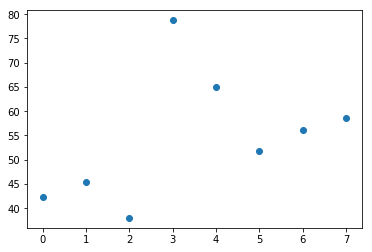

In [109]:
compare2feature(label_data.label, label_data.api_type_count)

看到相关系数很低，不足0.5；

#### lv1:label vs tid type count

pearson相关系数：0.435762532525
kendall相关系数：0.428571428571
spearman相关系数：0.547619047619


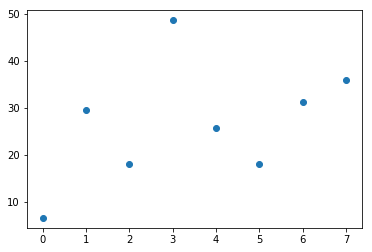

In [110]:
compare2feature(label_data.label, label_data.tid_type_count)

#### lv1:label vs api call count

pearson相关系数：0.812082952883
kendall相关系数：0.714285714286
spearman相关系数：0.809523809524


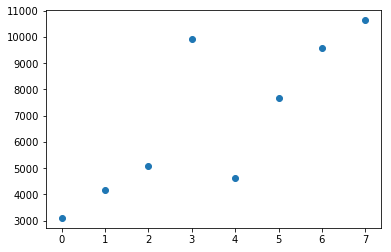

In [111]:
compare2feature(label_data.label, label_data.api_call_count)

### 分析api前缀，通过前缀对api进行分组

输出所有程序调用的api种类总数；

In [112]:
len(train_data.api.unique())

290

通过取前缀，将api分组；

In [113]:
api_list = train_data.api.unique()
api_prefix = []
UPPER = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
#api_list = ['RTZool', 'RootLoot', 'xyzLiu', 'xyzzz', 'ABC']
for api in api_list:
    if api[0] in UPPER:
        result = re.search(r'[a-z]', api)
        if result:
            prefix = api[:result.span()[0]]
        else:
            prefix = api
    else:
        result = re.search(r'[A-Z]', api)
        if result:
            prefix = api[:result.span()[0]]
        else:
            prefix = api
    api_prefix.append(prefix)
api_prefix = set(api_prefix)
print api_prefix
print len(api_prefix)

set(['getaddrinfo', 'shutdown', 'accept', 'ioctlsocket', 'connect', 'getsockname', 'IW', 'WSAS', 'WSAR', 'recv', 'system', 'send', 'select', 'listen', 'A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'sendto', 'M', 'L', 'O', 'N', 'P', '__exception__', 'R', 'U', 'T', 'W', 'SHG', 'closesocket', 'setsockopt', 'WSAC', 'URLD', 'socket', 'gethostbyname', 'bind', 'S', 'recvfrom', 'time'])
44


In [114]:
api_prefix = list(api_prefix)
api_prefix.sort(key=len, reverse=True) # 按长度排序保证了长的前缀不会一直无法被匹配到（被短的抢了，一种贪心思路）

通过取前缀，认为是一种对api的分簇方法，将api个数从295降低到了44；

In [115]:
train_data['api_prefix'] = train_data.api
train_data['api_prefix'] = train_data['api_prefix'].apply(lambda a:[ap for ap in api_prefix if a.startswith(ap)][0])
train_data['api_prefix'][:5000:1000]

0       L
1000    N
2000    L
3000    G
4000    N
Name: api_prefix, dtype: object

### 复杂特征构建：结合多个普通特征

#### lv3:构建file_id+api_tid组合特征

In [120]:
# agg:https://blog.csdn.net/u012706792/article/details/80892510
# col1:Api,col2:Tid/col1:Tid,col2:Api
def feature_combination(data_merge, data_orig, combination_feature, col1=None, col2=None, opts=None):
    # opts:count,min,max,median,std
    for opt in opts:
        gcc()
        print opt
        # 根据file_id+Api分组，针对Tid进行聚合运算
        train_split = data_orig.groupby(['file_id', col1])[col2].agg(
            {'fileid_' + col1 + '_' + col2 + '_' + str(opt): opt}).reset_index()
        # 重塑DataFrame
        train_split_ = pd.pivot_table(train_split, values='fileid_' + col1 + '_' + col2 + '_' + str(opt),
                        index=['file_id'], columns=[col1])
        new_cols = ['fileid_' + col1 + '_' + col2 + '_' + opt + '_' + str(col) for col in train_split_.columns]
        combination_feature.append(new_cols)
        train_split_.columns = new_cols
        train_split_.reset_index(inplace=True)
        # 合并数据到一个空DataFrame中
        data_merge = pd.merge(data_merge, train_split_, how='left', on='file_id')
    return data_merge, combination_feature

#t, cf = feature_combination(pd.DataFrame(train_data.file_id, columns=['file_id']), train_data, [], 'api_prefix', 'tid', ['count', 'min', 'max', 'median', 'std'])

（100000数据量下）看到在没有通过前缀对api进行分类前，api+tid最终有933列，而分类后，api_prefix+tid有135列；

## 建模

1. 读取全部数据；
2. 划分数据集；
3. 对训练数据，根据文件id分组，根据labe分组；
4. 相应字段归一化；
5. 训练kNN模型；
6. 使用验证数据计算模型得分，k为1；

In [15]:
train_data = pd.read_csv(train_path)

In [16]:
file_data = groupby_fileid(train_data)
file_data.head(5)

,file_id,label,api_type_count,tid_type_count,api_call_count
0,1,5,116,11,6786
1,2,2,30,4,816
2,3,0,42,1,463
3,4,0,51,9,2046
4,5,0,65,6,10002


In [17]:
df = file_data[['api_type_count','tid_type_count','api_call_count']]
df.head(5)
# min/max归一化处理
file_data[['api_type_count','tid_type_count','api_call_count']] = (df - df.min()) / (df.max() - df.min())
file_data = file_data.drop('file_id', axis=1)
file_data.head(5)

,label,api_type_count,tid_type_count,api_call_count
0,5,0.680473,0.00509165,0.00763902
1,2,0.171598,0.00152749,0.000917583
2,0,0.242604,0,0.000520151
3,0,0.295858,0.00407332,0.0023024
4,0,0.378698,0.00254582,0.0112598


由于数据是倾斜的，其中0和5文件很多，其余很少，这里考虑采取过抽样的方式来优化这一问题；

In [18]:
file_data.groupby('label').count()

,api_type_count,tid_type_count,api_call_count
label,,,
0,4978,4978,4978
1,502,502,502
2,1196,1196,1196
3,820,820,820
4,100,100,100
5,4289,4289,4289
6,515,515,515
7,1487,1487,1487


以4000为标准，对1,2,3,4,6,7进行过抽样；

df0 = file_data[file_data.label==0]
df5 = file_data[file_data.label==5]

df1 = file_data[file_data.label==1]
df1 = pd.concat([df1]*8, ignore_index=True)
df2 = file_data[file_data.label==2]
df2 = pd.concat([df2]*4, ignore_index=True)
df3 = file_data[file_data.label==3]
df3 = pd.concat([df3]*5, ignore_index=True)
df4 = file_data[file_data.label==4]
df4 = pd.concat([df4]*40, ignore_index=True)
df6 = file_data[file_data.label==6]
df6 = pd.concat([df6]*8, ignore_index=True)
df7 = file_data[file_data.label==7]
df7 = pd.concat([df7]*3, ignore_index=True)
file_data = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7], ignore_index=True)
file_data.groupby('label').count()

划分数据集

In [19]:
from sklearn.cross_validation import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(file_data.drop('label', axis=1),file_data.label, test_size=0.25, random_state=0)
print len(x_train)
print len(x_valid)

10415
3472


/home/kael/Software/anaconda2/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


x_train['label'] = y_train
x_data = x_train
label_data = groupby_label(x_data)
x_train = label_data.drop('label', axis=1)
y_train = label_data.label
y_train = pd.DataFrame(y_train, columns=['label'])
x_train

x_valid['label'] = y_valid
x_data = x_valid
file_data = groupby_fileid(x_data)
x_valid = file_data.drop(['label','file_id'], axis=1)
y_valid = file_data.label
y_valid = pd.DataFrame(y_valid, columns=['label'])

### 算法对比

#### kNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn = KNN(3)
knn.fit(x_train,y_train.astype('int'))
scores=knn.score(x_valid, y_valid.astype('int'))
print scores

0.702188940092


In [25]:
from sklearn.metrics import classification_report
y_pred = knn.predict(x_valid)
print classification_report(y_valid.astype('int'), y_pred)

             precision    recall  f1-score   support

          0       0.76      0.81      0.78      1283
          1       0.71      0.84      0.77       122
          2       0.71      0.71      0.71       318
          3       0.52      0.56      0.54       196
          4       0.21      0.24      0.22        17
          5       0.73      0.76      0.75      1017
          6       0.53      0.30      0.38       137
          7       0.53      0.36      0.43       382

avg / total       0.69      0.70      0.69      3472



<Container object of 8 artists>

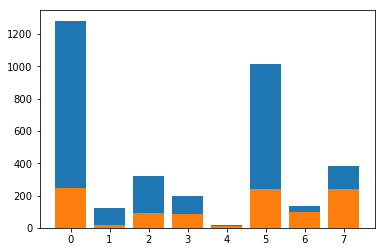

In [26]:
y_pred = knn.predict(x_valid)
y_pred_list = list(y_pred)
y_valid_list = list(y_valid)
class_result = {}
error_result = {}
for i in range(len(y_pred_list)):
    class_result[y_valid_list[i]] = class_result.get(y_valid_list[i], 0)+1
    if y_pred_list[i] != y_valid_list[i]:
        error_result[y_valid_list[i]] = error_result.get(y_valid_list[i], 0)+1

plt.bar(class_result.keys(), class_result.values())
plt.bar(error_result.keys(), error_result.values())

#### LGB

In [27]:
x_train.api_type_count = x_train.api_type_count.astype('float64')
x_train.api_call_count = x_train.api_call_count.astype('float64')
x_train.tid_type_count = x_train.tid_type_count.astype('float64')
y_train = y_train.astype('int')

x_valid.api_type_count = x_valid.api_type_count.astype('float64')
x_valid.api_call_count = x_valid.api_call_count.astype('float64')
x_valid.tid_type_count = x_valid.tid_type_count.astype('float64')
y_valid = y_valid.astype('int')

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import lightgbm as LGB

train_data_lgb=LGB.Dataset(x_train,label=y_train)
valid_data_lgb=LGB.Dataset(x_valid,label=y_valid)
params = {
    'learning_rate':0.1,
   'lambda_l1':0.2,
   'lambda_l2':0.2,
     'n_estimators':3000,
    'early_stopping_rounds':100,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8}

lgb=LGB.train(params,train_data_lgb,valid_sets=[valid_data_lgb])

print 'lgb params:'+str(params)
# 1、AUC
y_pred_pa = lgb.predict(x_valid)  # !!!注意lgm预测的是分数，类似 sklearn的predict_proba
y_valid_oh = label_binarize(y_valid, classes= [0,1,2,3,4,5,6,7])
print 'lgb auc：', roc_auc_score(y_valid_oh, y_pred_pa, average='micro')

# 2、模型报告
y_pred = y_pred_pa.argmax(axis=1)
print '输出模型报告：'
print(classification_report(y_valid, y_pred))

[1]	valid_0's multi_logloss: 1.5092
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.43606
[3]	valid_0's multi_logloss: 1.37761
[4]	valid_0's multi_logloss: 1.32842
[5]	valid_0's multi_logloss: 1.28629
[6]	valid_0's multi_logloss: 1.25022
[7]	valid_0's multi_logloss: 1.21746
[8]	valid_0's multi_logloss: 1.18833
[9]	valid_0's multi_logloss: 1.16349
[10]	valid_0's multi_logloss: 1.14171
[11]	valid_0's multi_logloss: 1.12122
[12]	valid_0's multi_logloss: 1.10333
[13]	valid_0's multi_logloss: 1.08724
[14]	valid_0's multi_logloss: 1.07241
[15]	valid_0's multi_logloss: 1.05884
[16]	valid_0's multi_logloss: 1.04622
[17]	valid_0's multi_logloss: 1.03493
[18]	valid_0's multi_logloss: 1.02434
[19]	valid_0's multi_logloss: 1.01421
[20]	valid_0's multi_logloss: 1.00492
[21]	valid_0's multi_logloss: 0.996473
[22]	valid_0's multi_logloss: 0.98886
[23]	valid_0's multi_logloss: 0.981288
[24]	valid_0's multi_logloss: 0.974874
[25]	valid_0's multi_logloss: 0.

[231]	valid_0's multi_logloss: 0.82277
[232]	valid_0's multi_logloss: 0.822422
[233]	valid_0's multi_logloss: 0.822295
[234]	valid_0's multi_logloss: 0.822248
[235]	valid_0's multi_logloss: 0.822305
[236]	valid_0's multi_logloss: 0.822113
[237]	valid_0's multi_logloss: 0.822198
[238]	valid_0's multi_logloss: 0.822045
[239]	valid_0's multi_logloss: 0.821963
[240]	valid_0's multi_logloss: 0.821811
[241]	valid_0's multi_logloss: 0.821755
[242]	valid_0's multi_logloss: 0.821715
[243]	valid_0's multi_logloss: 0.821791
[244]	valid_0's multi_logloss: 0.821624
[245]	valid_0's multi_logloss: 0.821496
[246]	valid_0's multi_logloss: 0.821557
[247]	valid_0's multi_logloss: 0.821465
[248]	valid_0's multi_logloss: 0.821542
[249]	valid_0's multi_logloss: 0.821307
[250]	valid_0's multi_logloss: 0.821136
[251]	valid_0's multi_logloss: 0.821071
[252]	valid_0's multi_logloss: 0.821135
[253]	valid_0's multi_logloss: 0.820952
[254]	valid_0's multi_logloss: 0.820791
[255]	valid_0's multi_logloss: 0.820702
[

#### SVM

### 模型融合

### 模型迭代过程总结

1. 基于统计方法构建特征V1：
    1. 做了file id分组统计，构建新特征（api调用类型数、线程数、api调用总数）；
    2. 准确率接近70%（注意这是个多分类问题，且分类不均衡，看到，类别1,4非常少，而0和5很多，而在预测错误的占比上看出，相对于0和5，其余几类的错误率更高，这也是因为kNN的k取值问题导致数量少的类别较难被选中，这个不平衡带来的问题kNN难以处理，需要考虑后续优化方案）；
    3. 这只是简单的根据每个文件分组构造特征，最重要的没有利用的信息是index，即api调用时序，这个考虑用HMM来做，今天研究一下怎么用到HMM上，并且还有个问题是要求是输出八个类型的概率，这个可以由kNN的k中的组成比例来实现，不是问题；

2. 基于统计方法构建特征V2：
    1. 做了过抽样；
    2. 得到81%的准确率，明显看到1,2,3,4,6的错误率下降了很多；
    
3. 基于统计方法构建特征V3：
    1. 切换LGB模型，并进行相应的调参，得到91%的准确率；

## 测试结果

In [31]:
train_data = None
file_data = None
x_train, y_train, x_valid, y_valid = None, None, None, None

In [32]:
test_data = pd.read_csv(test_path)
test_file_data = groupby_fileid_nolabel(test_data)
fileid_data = test_file_data.file_id
test_file_data = test_file_data.drop('file_id', axis=1)

test_file_data.api_type_count = test_file_data.api_type_count.astype('float64')
test_file_data.api_call_count = test_file_data.api_call_count.astype('float64')
test_file_data.tid_type_count = test_file_data.tid_type_count.astype('float64')
fileid_data = fileid_data.astype('int')

In [33]:
def create_test_result(model, name):
    test_pred = model.predict(test_file_data)
    test_result = pd.DataFrame(columns=['file_id', 'prob0', 'prob1', 'prob2', 'prob3', 
                                        'prob4', 'prob5', 'prob6', 'prob7'])
    for i in range(len(fileid_data)):
        prob = [0]*8
        if name.startswith('knn'):
            prob[test_pred[i]]=1
        elif name.startswith('lgb'):
            prob = test_pred[i]
        test_result = test_result.append([{'file_id':fileid_data.iloc[i],
                                      'prob0':prob[0],'prob1':prob[1],'prob2':prob[2],'prob3':prob[3],
                                      'prob4':prob[4],'prob5':prob[5],'prob6':prob[6],'prob7':prob[7],}], ignore_index=True)
    test_result.to_csv('./result/'+name+'.csv', index=0)
    print './result/'+name+'.csv'

In [34]:
create_test_result(knn, 'knn_v4')

./result/knn_v4.csv


基于统计方法构建特征V2：
- 模型：kNN，k为5；
- 验证集得分：0.81,0.81,0.80；
- 文件名：knn_v3.csv
- 提交格式：0/1；
- 提交得分：logloss 26+；

In [71]:
create_test_result(lgb, 'lgb_v3')

./result/lgb_v3.csv


基于统计方法构建特征V3：
- 模型：LGB；
- 验证集得分：0.91,0.91,0.91；
- 提交格式：0/1；
- 提交得分：logloss 9+；

In [72]:
test_data = None
test_file_data = None
fileid_data, test_file_data = None, None

## 参考

[HMM](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#building-hmm-and-generating-samples)
[数据倾斜](https://www.cnblogs.com/gaoss/p/9677466.html)
[天池高分分享](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12586969.1002.3.75c867b5PiAURi&postId=56989)
[中文文本分类](https://www.jianshu.com/p/dc00a5d597ed)